In [ ]:
import pickle
import os
import string
import warnings

import nltk
import numpy as np
import pandas as pd
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC

In [ ]:
warnings.filterwarnings('ignore')


In [ ]:
from google.colab import files

# Загрузка kaggle.json
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"msrumskgmailcom","key":"1d35a2724d87e9c282ccf5ac65e14c82"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mikhailklemin/kinopoisks-movies-reviews

Dataset URL: https://www.kaggle.com/datasets/mikhailklemin/kinopoisks-movies-reviews
License(s): unknown


In [ ]:
!unzip kinopoisks-movies-reviews.zip -d /content/

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/dataset/pos/88738-11.txt  
  inflating: /content/dataset/pos/88738-12.txt  
  inflating: /content/dataset/pos/88738-13.txt  
  inflating: /content/dataset/pos/88738-14.txt  
  inflating: /content/dataset/pos/88738-15.txt  
  inflating: /content/dataset/pos/88738-2.txt  
  inflating: /content/dataset/pos/88738-3.txt  
  inflating: /content/dataset/pos/88738-4.txt  
  inflating: /content/dataset/pos/88738-6.txt  
  inflating: /content/dataset/pos/88738-7.txt  
  inflating: /content/dataset/pos/88749-0.txt  
  inflating: /content/dataset/pos/88749-1.txt  
  inflating: /content/dataset/pos/88749-2.txt  
  inflating: /content/dataset/pos/887519-0.txt  
  inflating: /content/dataset/pos/887519-1.txt  
  inflating: /content/dataset/pos/887519-2.txt  
  inflating: /content/dataset/pos/887519-3.txt  
  inflating: /content/dataset/pos/887519-4.txt  
  inflating: /content/dataset/pos/887519-5.txt  
  inflati

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
import os
import numpy as np
import pandas as pd

prop = 0.15
path = '/content/dataset'

df = pd.DataFrame(columns=['review', 'sentiment'])

for directory in os.listdir(path):
    dir_path = os.path.join(path, directory)
    if os.path.isdir(dir_path):
        dirs = np.array(os.listdir(dir_path))
        np.random.shuffle(dirs)

        if len(dirs) > 0:
            rews_fhs = np.random.choice(dirs, round(len(dirs) * prop), replace=False)
            for rew_fh in rews_fhs:
                file_path = os.path.join(dir_path, rew_fh)
                with open(file_path, encoding='utf-8') as f:
                    review = f.read()
                    current_df = pd.DataFrame({'review': [review], 'sentiment': [directory]})
                    df = pd.concat([df, current_df], ignore_index=True)
                print(f"Файл {rew_fh} успешно добавлен.")
        else:
            print(f"Папка {directory} пуста.")

df = df.sample(frac=1).reset_index(drop=True)
print(df.head(5))


Выходные данные были обрезаны до нескольких последних строк (5000).
Файл 408961-3.txt успешно добавлен.
Файл 394047-6.txt успешно добавлен.
Файл 934759-0.txt успешно добавлен.
Файл 77450-6.txt успешно добавлен.
Файл 18573-0.txt успешно добавлен.
Файл 572230-94.txt успешно добавлен.
Файл 905043-0.txt успешно добавлен.
Файл 1892-4.txt успешно добавлен.
Файл 4392-8.txt успешно добавлен.
Файл 385580-0.txt успешно добавлен.
Файл 41303-6.txt успешно добавлен.
Файл 46250-0.txt успешно добавлен.
Файл 281399-0.txt успешно добавлен.
Файл 3784-55.txt успешно добавлен.
Файл 258759-86.txt успешно добавлен.
Файл 718228-10.txt успешно добавлен.
Файл 259251-14.txt успешно добавлен.
Файл 965632-0.txt успешно добавлен.
Файл 3844-0.txt успешно добавлен.
Файл 398927-10.txt успешно добавлен.
Файл 2281-5.txt успешно добавлен.
Файл 81561-76.txt успешно добавлен.
Файл 103414-56.txt успешно добавлен.
Файл 195429-7.txt успешно добавлен.
Файл 253245-7.txt успешно добавлен.
Файл 17110-0.txt успешно добавлен.
Файл

In [ ]:
df.head(5)

,review,sentiment
0,Вообще посмотреть фильм 'Соблазнитель' мне хот...,pos
1,Довольно веселый трэш по-французски. Этакая Ба...,neu
2,Самое главное отрицательное впечатление от это...,neg
3,"- Ты уезжаешь, чтобы любить вечно?\n- Я уезжаю...",neu
4,Пожалуй не будет преувеличением заявление о то...,pos


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19751 entries, 0 to 19750
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     19751 non-null  object
 1   sentiment  19751 non-null  object
dtypes: object(2)
memory usage: 308.7+ KB


<Axes: xlabel='count', ylabel='sentiment'>

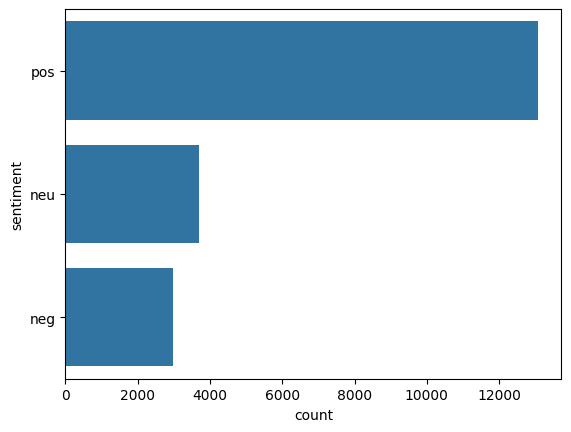

In [ ]:
sns.countplot(df['sentiment'])

In [ ]:
le = LabelEncoder()
df['sentiment'] = le.fit_transform(df['sentiment'])

le.classes_

array(['neg', 'neu', 'pos'], dtype=object)

In [ ]:
#Formatting text, removing unnecessary characters, reducing text to lower case:
def standardize_text(df, content_field):
    df[content_field] = df[content_field].str.replace(r"http\S+", "")
    df[content_field] = df[content_field].str.replace(r"@\S+", "")
    df[content_field] = df[content_field].str.replace(r"[^А-Яа-яA-Za-z0-9Ёё(),!?@\'\`\"\_\n]", " ")
    df[content_field] = df[content_field].str.replace(r"[Ёё]", "е")
    df[content_field] = df[content_field].str.replace(r"[\t\n]", "")
    df[content_field] = df[content_field].str.replace(r"[^А-Яа-яa-zA-Z]", " ")
    df[content_field] = df[content_field].str.lower()
    return df
standardize_text(df, "review")


,review,sentiment
0,вообще посмотреть фильм 'соблазнитель' мне хот...,2
1,довольно веселый трэш по-французски. этакая ба...,1
2,самое главное отрицательное впечатление от это...,0
3,"- ты уезжаешь, чтобы любить вечно?\n- я уезжаю...",1
4,пожалуй не будет преувеличением заявление о то...,2
...,...,...
19746,"как говорят сами братья коэн, замысел этого пр...",2
19747,планета криптон оказалась слабее населяющей её...,1
19748,предлагается вашему вниманию заметка о кинофил...,2
19749,"никогда не понимал людей, которые способны смо...",2


In [ ]:
import nltk

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stemmer = SnowballStemmer('russian')
corpus = []

for i in range(len(df)):
    review = df['review'][i]
    review = review.split()
    review = [word for word in review if word not in set(stopwords.words('russian'))]
    review = [stemmer.stem(word) for word in review]
    review = ' '.join(review)
    corpus.append(review)

In [ ]:
tfidf = TfidfVectorizer(ngram_range=(1, 2))
X = tfidf.fit_transform(corpus)
X.shape


(19751, 3055653)

In [ ]:
y = df['sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
#Learning SVM classification:
classifier = LinearSVC()
classifier.fit(X_train, y_train)

LinearSVC()

In [ ]:
y_pred = classifier.predict(X_test)


In [ ]:
acc = accuracy_score(y_test, y_pred)
acc

0.7410782080485953

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.44      0.55       580
           1       0.62      0.08      0.15       737
           2       0.74      0.99      0.85      2634

    accuracy                           0.74      3951
   macro avg       0.70      0.50      0.52      3951
weighted avg       0.72      0.74      0.68      3951

